In [ ]:
import plotly.express as px
import pandas as pd
import requests
import arrow
import sys # added!
sys.path.append("../app") # added!

In [43]:
from io import StringIO

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///../data/gov.db')


In [ ]:
# TODO: convert to dictionary to name

from config import TRUST_INFO

YESTERDAY = str(arrow.now().shift(days=-1).format("YYYY-MM-DD"))

In [ ]:
URL_HOSP_CASES = f"https://coronavirus.data.gov.uk/api/v2/data?areaType=nhsTrust&release={YESTERDAY}&metric=hospitalCases&format=json"

In [35]:
URL_CASES_BY_AGE = f"https://api.coronavirus.data.gov.uk/v2/data?areaType=region&areaCode=E12000007&metric=newCasesBySpecimenDateAgeDemographics&format=csv"

In [47]:
def request_gov_uk(url, table, engine, format='json') -> pd.DataFrame:
    """
    Import COVID information as per the gov.uk API here
    but checks to see if the same request has already been run
    url: API connection
    table: table to store data in local SQLite
    conn: connection to local db for storing data and logging requests
    format: json or csv
    """
    with engine.connect() as conn:
        requests_df = pd.read_sql('requests_log', conn)

        if url in requests_df.request.values:
            df = pd.read_sql(table, conn)
        
        else:
            response = requests.get(url)
            if format == 'json':
                df = pd.json_normalize(response.json(), record_path="body")
            elif format == 'csv':
                df = pd.read_csv(StringIO(response.text))
            else:
                raise NotImplementedError
            df.to_sql(table, conn, if_exists='replace')

            request_log = pd.DataFrame({
                'request': [url],
                'table': [table],
                'request_ts': [str(arrow.now())]
            })
            request_log.to_sql('requests_log', conn, if_exists='append')
    return df


In [49]:
df = request_gov_uk(URL_CASES_BY_AGE, 'cases_by_age', engine, format='csv')

In [50]:
df

,areaCode,areaName,areaType,date,age,cases,rollingSum,rollingRate
0,E12000007,London,region,2021-12-15,00_04,345,1863,312.7
1,E12000007,London,region,2021-12-15,00_59,26305,109669,1462.6
2,E12000007,London,region,2021-12-15,05_09,824,5510,908.7
3,E12000007,London,region,2021-12-15,10_14,1179,6800,1234.7
4,E12000007,London,region,2021-12-15,15_19,1350,6170,1300.4
...,...,...,...,...,...,...,...,...
14823,E12000007,London,region,2020-02-11,75_79,0,0,0.0
14824,E12000007,London,region,2020-02-11,80_84,0,0,0.0
14825,E12000007,London,region,2020-02-11,85_89,0,0,0.0
14826,E12000007,London,region,2020-02-11,90+,0,0,0.0


In [51]:
def clean_popn_cases(df):
    """
    Clean population cases (London)
    df : data frame of population cases by age
    """
    df["date"] = pd.to_datetime(df["date"])
    df.drop(["areaType", "areaCode", "areaType" ], axis=1, inplace=True)
    return df

In [52]:
df = clean_popn_cases(df)

In [65]:
import plotly.graph_objects as go

fig = go.Figure()

In [66]:
age_bands = df.age.unique().tolist()
age_bands = list(set(age_bands) - set(['60+', '00_59', 'unassigned']))
age_bands

['00_04',
 '70_74',
 '65_69',
 '90+',
 '20_24',
 '30_34',
 '50_54',
 '40_44',
 '75_79',
 '80_84',
 '85_89',
 '10_14',
 '35_39',
 '05_09',
 '45_49',
 '60_64',
 '25_29',
 '15_19',
 '55_59']

In [67]:
for age in age_bands:
    _df = df.loc[df.age == age]
    fig.add_trace(
            go.Scatter(
                name=age,
                x=_df.date,
                y=_df.cases,
            )
        )

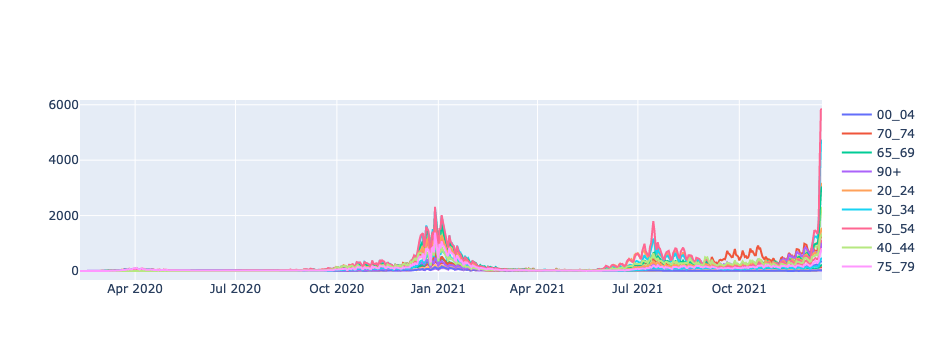

In [68]:
fig

In [54]:
fig.add_trace(go.Scatter(x=df.date, y=df.cases, fill=df.age))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
df.head()

,index,areaType,areaCode,areaName,date,hospitalCases
0,0,nhsTrust,RT5,Leicestershire Partnership NHS Trust,2021-12-14,5
1,1,nhsTrust,RT5,Leicestershire Partnership NHS Trust,2021-12-13,5
2,2,nhsTrust,RT5,Leicestershire Partnership NHS Trust,2021-12-12,6
3,3,nhsTrust,RT5,Leicestershire Partnership NHS Trust,2021-12-11,5
4,4,nhsTrust,RT5,Leicestershire Partnership NHS Trust,2021-12-10,4


In [ ]:
def clean_hosp_cases(df, TRUST_INFO):
    """
    Clean hosp cases
    df : data frame of hospital cases
    TRUST_INFO: data frame of trust information
    """
    trusts_london = TRUST_INFO[TRUST_INFO.inLondon01][['areaCode','shortName', 'sectorName', 'inNCL01']]
    df = df.merge(trusts_london, how='inner', on='areaCode')
    df["date"] = pd.to_datetime(df["date"])
    df.drop(['index', 'areaType'], axis=1, inplace=True)
    return df


In [ ]:
df2 = clean_hosp_cases(df, TRUST_INFO)

In [ ]:
df2.areaCode.unique().tolist()

['RAS',
 'RYX',
 'RV3',
 'RP4',
 'RJ2',
 'RNK',
 'RKE',
 'RRP',
 'RQM',
 'RYJ',
 'RWK',
 'RJ6',
 'RJZ',
 'RAN',
 'RPY',
 'RAT',
 'RQY',
 'RAL',
 'RKL',
 'RT3',
 'RJ7',
 'R1H',
 'RJ1',
 'R1K',
 'RPG',
 'RF4',
 'RAP',
 'RAX',
 'RP6',
 'RVR',
 'RY9',
 'RRV',
 'RV5',
 'RQX']

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()

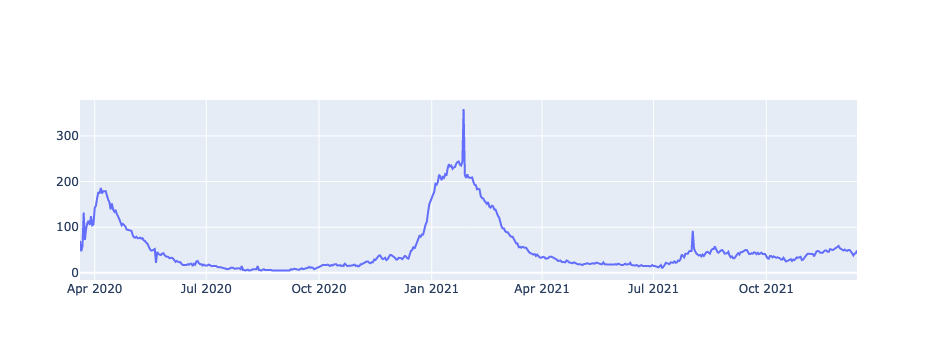

In [ ]:
fig.add_trace(go.Scatter(x=df.date, y=df.hospitalCases))

In [ ]:
df

,areaType,areaCode,areaName,date,hospitalCases
0,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-12-14,49
1,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-12-13,43
2,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-12-12,42
3,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-12-11,38
4,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-12-10,43
...,...,...,...,...,...
626,nhsTrust,RRV,University College London Hospitals NHS Founda...,2020-03-24,72
627,nhsTrust,RRV,University College London Hospitals NHS Founda...,2020-03-23,132
628,nhsTrust,RRV,University College London Hospitals NHS Founda...,2020-03-22,58
629,nhsTrust,RRV,University College London Hospitals NHS Founda...,2020-03-21,47


In [ ]:
df.loc[df.hospitalCases==49]

,areaType,areaCode,areaName,date,hospitalCases
0,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-12-14,49
9,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-12-05,49
11,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-12-03,49
25,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-11-19,49
26,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-11-18,49
110,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-08-25,49
118,nhsTrust,RRV,University College London Hospitals NHS Founda...,2021-08-17,49
571,nhsTrust,RRV,University College London Hospitals NHS Founda...,2020-05-18,49
572,nhsTrust,RRV,University College London Hospitals NHS Founda...,2020-05-17,49
